/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
352/352 - 11s - 32ms/step - accuracy: 0.3112 - loss: 1.9403 - val_accuracy: 0.3008 - val_loss: 2.0051 - learning_rate: 0.0100
Epoch 2/50
352/352 - 1s - 3ms/step - accuracy: 0.3838 - loss: 1.7139 - val_accuracy: 0.3796 - val_loss: 1.7542 - learning_rate: 0.0090
Epoch 3/50
352/352 - 1s - 3ms/step - accuracy: 0.4092 - loss: 1.6429 - val_accuracy: 0.3986 - val_loss: 1.7169 - learning_rate: 0.0082
Epoch 4/50
352/352 - 1s - 3ms/step - accuracy: 0.4257 - loss: 1.6037 - val_accuracy: 0.4208 - val_loss: 1.6643 - learning_rate: 0.0074
Epoch 5/50
352/352 - 1s - 4ms/step - accuracy: 0.4379 - loss: 1.5663 - val_accuracy: 0.4416 - val_loss: 1.5731 - learning_rate: 0.0067
Epoch 6/50
352/352 - 2s - 5ms/step - accuracy: 0.4494 - loss: 1.5400 - val_accuracy: 0.4584 - val_loss: 1.5283 - learning_rate: 0.0061
Epoch 7/50
352/352 - 2s - 4ms/step - accuracy: 0.4566 - loss: 1.5161 - val_accuracy: 0.4628 - val_loss: 1.5002 - learning_rate: 0.0055
Epoch 8/50
352/352 - 1s - 3ms/step - accuracy: 0.4608

<Figure size 1000x1000 with 0 Axes>

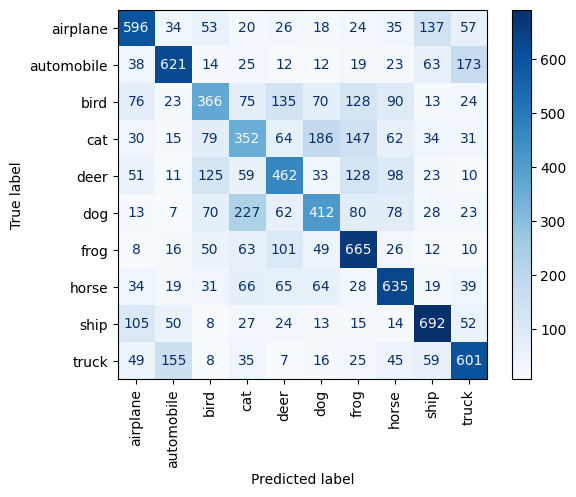


Per-Class Accuracy:
airplane: 59.60%
automobile: 62.10%
bird: 36.60%
cat: 35.20%
deer: 46.20%
dog: 41.20%
frog: 66.50%
horse: 63.50%
ship: 69.20%
truck: 60.10%


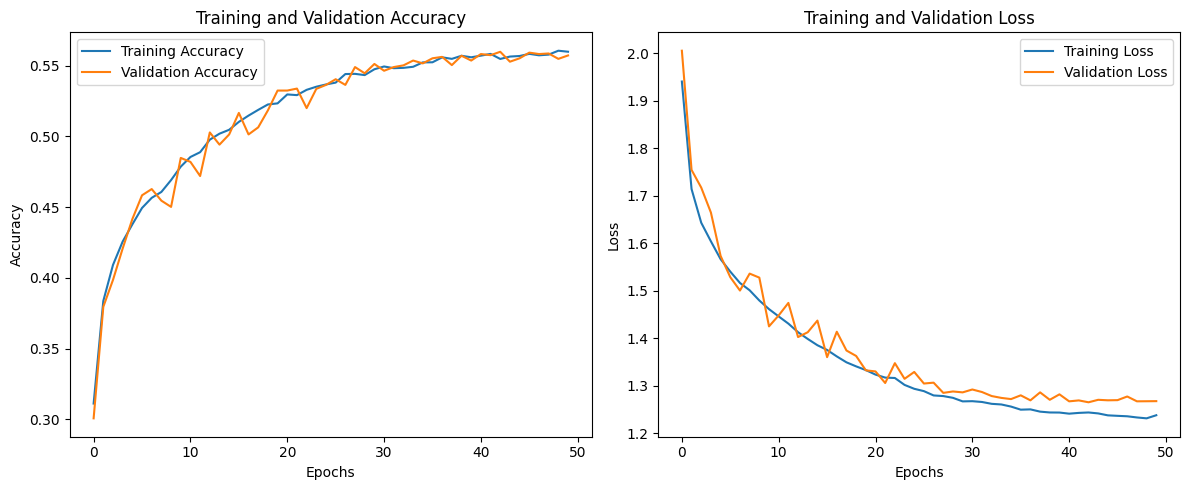

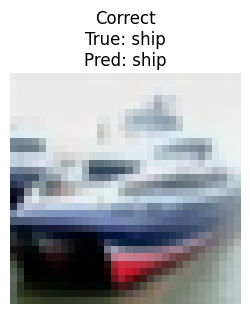

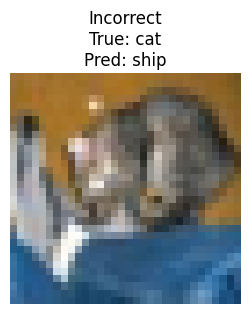

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score

(x_train, y_train), (x_test, y_test) = cifar10.load_data()

# preprocessing
x_train = x_train.reshape(x_train.shape[0], -1).astype('float32') / 255.0
x_test = x_test.reshape(x_test.shape[0], -1).astype('float32') / 255.0

# one-hot encoding
y_train_onehot = to_categorical(y_train, 10)
y_test_onehot = to_categorical(y_test, 10)

labels = ['airplane', 'automobile', 'bird', 'cat', 'deer',
               'dog', 'frog', 'horse', 'ship', 'truck']

model = Sequential([
    Dense(128, input_dim=x_train.shape[1], activation='relu'),
    BatchNormalization(),
    Dropout(0.15),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.35),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(10, activation='softmax')
])

model.compile(optimizer=Adam(learning_rate=0.01),
              loss='categorical_crossentropy',
              metrics=['accuracy'])


early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=15,
    restore_best_weights=True
)
def learning_rate_scheduler(epoch, lr):
    if epoch < 1:
        return float(lr)
    else:
        return float(lr * tf.math.exp(-0.1))
lr_scheduler = LearningRateScheduler(learning_rate_scheduler)

history = model.fit(
    x_train, y_train_onehot,
    epochs=50,
    batch_size=128,
    validation_split=0.1,
    callbacks=[early_stopping, lr_scheduler],
    verbose=2
)


test_loss, test_accuracy = model.evaluate(x_test, y_test_onehot)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

y_pred = np.argmax(model.predict(x_test), axis=1)


cm = confusion_matrix(y_test.flatten(), y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
plt.figure(figsize=(10, 10))
disp.plot(cmap=plt.cm.Blues, xticks_rotation='vertical')
plt.show()


class_report = classification_report(y_test.flatten(), y_pred, target_names=labels)
per_class_accuracy = {}
for i, class_name in enumerate(labels):
    class_mask = y_test.flatten() == i
    class_true = y_test.flatten()[class_mask]
    class_pred = y_pred[class_mask]
    per_class_accuracy[class_name] = accuracy_score(class_true, class_pred)

print("\nPer-Class Accuracy:")
for class_name, accuracy in per_class_accuracy.items():
    print(f"{class_name}: {accuracy * 100:.2f}%")


plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

correct_indices = np.where(y_pred == y_test.flatten())[0]
incorrect_indices = np.where(y_pred != y_test.flatten())[0]


def plot_single_example(idx, title):
    plt.figure(figsize=(3, 3))
    plt.imshow(x_test[idx].reshape(32, 32, 3))
    plt.title(title, fontsize=12)
    plt.axis("off")
    plt.show()

if len(correct_indices) > 0:
    correct_idx = correct_indices[0]
    plot_single_example(
        correct_idx,
        title=f"Correct\nTrue: {labels[y_test.flatten()[correct_idx]]}\nPred: {labels[y_pred[correct_idx]]}"
    )
else:
    print("There are no correct predictions to show.")

if len(incorrect_indices) > 0:
    incorrect_idx = incorrect_indices[0]
    plot_single_example(
        incorrect_idx,
        title=f"Incorrect\nTrue: {labels[y_test.flatten()[incorrect_idx]]}\nPred: {labels[y_pred[incorrect_idx]]}"
    )
else:
    print("There are no incorrect predictions to show.")

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Ορίστε το δικό σας όνομα αρχείου / φακέλου
save_path = '/content/gdrive/My Drive/MLP333.keras'

# Αποθήκευση του μοντέλου
model.save(save_path)
print(f"Το μοντέλο αποθηκεύτηκε στη διαδρομή: {save_path}")

Το μοντέλο αποθηκεύτηκε στη διαδρομή: /content/gdrive/My Drive/MLP333.keras


In [ ]:
import pickle

# 1. Καθορισμός διαδρομής για το history
history_save_path = '/content/gdrive/My Drive/MLP_history333.pkl'

# 2. Αποθήκευση του history object
with open(history_save_path, 'wb') as file:
    pickle.dump(history.history, file) # Αποθηκεύουμε το λεξικό .history

print(f"Το ιστορικό αποθηκεύτηκε στη διαδρομή: {history_save_path}")

Το ιστορικό αποθηκεύτηκε στη διαδρομή: /content/gdrive/My Drive/MLP_history333.pkl
